In [145]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [146]:
def load_and_convert_images(image_path):
    """
    Load an image from the given path and convert it to grayscale
    if it's not already grayscale.
    """
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:  # If the image has 3 channels, it's in color (BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # Image is already in grayscale
        gray = image
    
    return image, gray

In [147]:
def detect_and_compute_sift(gray):
    """
    Detect keypoints and compute descriptors using SIFT.
    """
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
   
    return keypoints, descriptors

In [148]:
def bf_matcher(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

In [149]:
def ratio_test(descriptors1, descriptors2, ratio=0.75):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    return good_matches

In [150]:
def cross_validation_test(keypoints1, keypoints2, matches, epipolar_threshold=0.01):
    # Convert keypoints to numpy arrays
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
    
    # Calculate the Fundamental Matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    
    # Apply epipolar geometry validation
    final_matches = []
    for i, m in enumerate(matches):
        if mask[i]:  # Only consider inliers according to the RANSAC mask
            pt1 = np.append(pts1[i], 1)
            pt2 = np.append(pts2[i], 1)
            # Compute the epipolar constraint error
            error = np.abs(np.dot(pt2.T, np.dot(F, pt1)))
            if error < epipolar_threshold:  # Validate match against epipolar geometry
                final_matches.append(m)
    
    # Return the inliers and the Fundamental Matrix
    return final_matches, F


In [151]:
def bf_ratio_cross_validation(keypoints1, keypoints2, descriptors1, descriptors2, ratio=0.75, epipolar_threshold=0.01):
    # Step 1: Apply BF with Ratio Test
    good_matches = ratio_test(descriptors1, descriptors2, ratio)
    
    # Step 2: Apply Cross-Validation Test
    final_matches, F = cross_validation_test(keypoints1, keypoints2, good_matches, epipolar_threshold)
    
    return final_matches, F

In [152]:
def plot_keypoints(image, keypoints, title='Keypoints'):
    # Create a copy of the image to draw keypoints
    img_with_keypoints = image.copy()
    
    # Iterate over keypoints and draw each one with a random color
    for keypoint in keypoints:
        # Generate a random color
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        # Draw the keypoint on the image
        cv2.drawKeypoints(img_with_keypoints, [keypoint], img_with_keypoints, color=color, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Convert to RGB format for Matplotlib display
    img_rgb = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
    
    return img_rgb

In [153]:
def plot_matches(image1, keypoints1, image2, keypoints2, matches):
    # Ensure matches are in the correct format
    if not isinstance(matches, list) or not all(isinstance(m, cv2.DMatch) for m in matches):
        raise ValueError("Matches should be a list of cv2.DMatch objects.")
    
    # Draw matches between the two images
    img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Convert to RGB format for Matplotlib display
    img_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    return img_rgb

In [154]:
def display_image(img_rgb, title='Image', figsize=(8, 6), subplot=None):
    """
    Display an image using Matplotlib, with an optional subplot.

    Parameters:
    - img_rgb: The image in RGB format to be displayed.
    - title: Title of the plot (default is 'Image').
    - figsize: Size of the figure (default is (8, 6)).
    - subplot: A tuple (nrows, ncols, index) for creating subplots. If None, no subplot is created.
    """
    if subplot:
        plt.subplot(subplot[0], subplot[1], subplot[2])
    else:
        plt.figure(figsize=figsize)
    
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    
    if not subplot:
        plt.show()

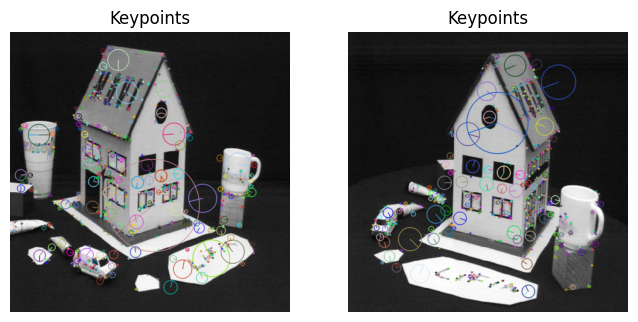

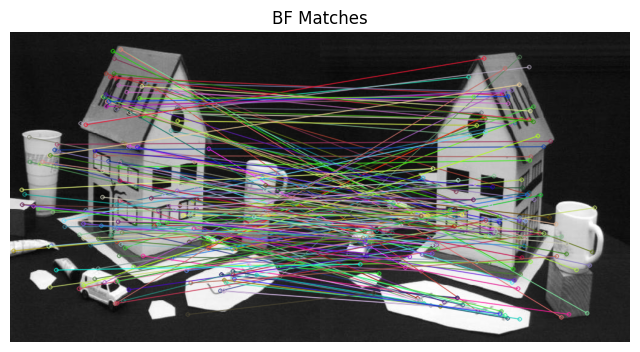

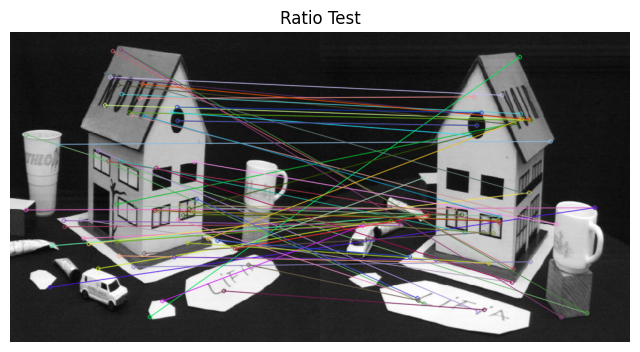

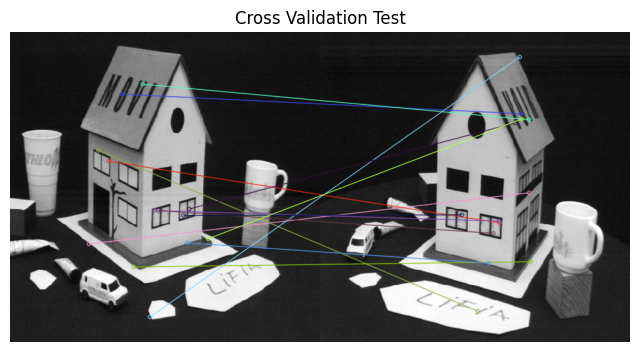

In [155]:
image1_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\3. Epi polar Geomatry\\3) Epipolar Geometry & 8-Point Algorithm\\images\\image_left.jpg'
image2_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\3. Epi polar Geomatry\\3) Epipolar Geometry & 8-Point Algorithm\\images\\image_right.jpg'

image1,gray1=load_and_convert_images(image1_path)
image2,gray2=load_and_convert_images(image2_path)

keypoints1,descriptors1=detect_and_compute_sift(gray1)
keypoints2,descriptors2=detect_and_compute_sift(gray2)

image_keypoints1=plot_keypoints(image1, keypoints1, title='Keypoints')
image_keypoints2=plot_keypoints(image2, keypoints2, title='Keypoints')

plt.figure(figsize=(8, 8))
display_image(image_keypoints1, title='Keypoints', subplot=(2,2,1))
display_image(image_keypoints2, title='Keypoints', subplot=(2,2,2))

bf_matches=bf_matcher(descriptors1, descriptors2)

image_bfmatches=plot_matches(image1, keypoints1, image2, keypoints2, bf_matches)
display_image(image_bfmatches, title='BF Matches')

ratiotest_matches=ratio_test(descriptors1, descriptors2)

image_ratiotest=plot_matches(image1, keypoints1, image2, keypoints2, ratiotest_matches)
display_image(image_ratiotest, title='Ratio Test')

cross_matches,F=bf_ratio_cross_validation(keypoints1, keypoints2, descriptors1, descriptors2)

image_cross=plot_matches(image1, keypoints1, image2, keypoints2, cross_matches)
display_image(image_cross, title='Cross Validation Test')
